### Import the libraries

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### 1. Problem Statement

Predict the trend of Bitcoin closing price using ARIMA model, by leveraging the historical closing price data spanning the past 5 years.

### 2. Input data

The input data is extracted from Yahoo Finance for Bitcoin (symbol = 'BTC-USD') using yfinancefor the past 5 years in the date range from '2018-05-01' to '2023-06-14'.The .csv file for the same is loaded here

In [56]:
df = pd.read_excel('Bitcoin_data.xlsx')
df.head()

,Date,Close
0,2018-04-30,9240.549805
1,2018-05-01,9119.009766
2,2018-05-02,9235.919922
3,2018-05-03,9743.860352
4,2018-05-04,9700.759766


In [57]:
df.tail()

,Date,Close
1836,2023-05-10,27621.755859
1837,2023-05-11,27000.789062
1838,2023-05-12,26804.990234
1839,2023-05-13,26784.078125
1840,2023-05-14,26930.638672


In [58]:
data1 = df[['Date', 'Close']]
data1

,Date,Close
0,2018-04-30,9240.549805
1,2018-05-01,9119.009766
2,2018-05-02,9235.919922
3,2018-05-03,9743.860352
4,2018-05-04,9700.759766
...,...,...
1836,2023-05-10,27621.755859
1837,2023-05-11,27000.789062
1838,2023-05-12,26804.990234
1839,2023-05-13,26784.078125


In [59]:
data = data1.set_index('Date')
#daa.sort_index(inplace=True)

In [6]:
data.head()

,Close
Date,
2018-04-30,9240.549805
2018-05-01,9119.009766
2018-05-02,9235.919922
2018-05-03,9743.860352
2018-05-04,9700.759766


In [7]:
data.isna().sum()

Close    0
dtype: int64

In [8]:
data['Close'].describe()

count     1841.000000
mean     21331.983589
std      16740.421878
min       3236.761719
25%       7951.580078
50%      14833.753906
75%      33560.707031
max      67566.828125
Name: Close, dtype: float64

#### 2.1 Visualizing the Closing Price

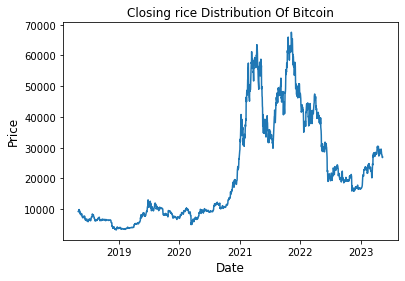

In [60]:
plt.plot(data)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Closing rice Distribution Of Bitcoin')
plt.show()

#### 2.2 White Noise

A series is called WN when it follows IID with mean=0

In [10]:
white_noise = np.random.normal(loc=data.Close.mean(), scale = data.Close.std(), size = len(df))
data["WN_Close"] = white_noise

In [11]:
data["WN_Close"].describe()

count     1841.000000
mean     20998.938645
std      16952.915467
min     -36095.918894
25%       9250.262212
50%      21082.967620
75%      32252.619274
max      83651.197778
Name: WN_Close, dtype: float64

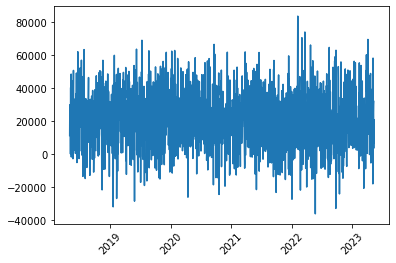

<Figure size 1008x576 with 0 Axes>

In [12]:
plt.plot(data['WN_Close'], label="White Noise")
plt.xticks(rotation=45)
plt.figure(figsize = (14,8))
plt.show()

#### 2.3 Percentage Change 

= ((Yt - Yt-1)/Yt-1)*100

In [61]:
data["Close_pct"] = data.Close.pct_change(1).mul(100)

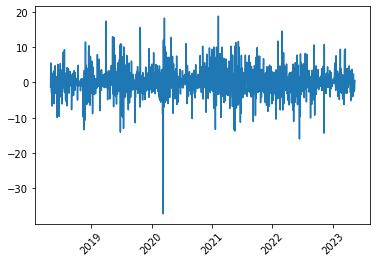

<Figure size 864x288 with 0 Axes>

In [62]:
plt.plot(data["Close_pct"])
plt.xticks(rotation=45)
plt.figure(figsize = (12,4))
plt.show()

#### 2.4 Normalized Value of Close and Z Score of Close

Normalized Score = [ Xi/base(X1))]*100

Z Score = ((X1 - Mean(X))/std(X)

In [63]:
base_value = data.Close.iloc[0]
data["Close_norm"] = data.Close.div(base_value).mul(100)

In [64]:
mean_dev = data.Close.sub(data.Close.mean())
data["Z_Close"] = mean_dev.div(data.Close.std())

### 3. Remove trend and seasonality with differencing

In case of differencing to make the time series stationary the current value is subtracted with the previous values. Due to this the mean is stabilized and hence the chances of stationarity of time series are increased.

In [71]:
data["Close_diff"]= data.Close.diff().dropna()

In [72]:
data.head()

,Close,Close_pct,Close_norm,Z_Close,Close_diff
Date,,,,,
2018-04-30,9240.549805,NaN,100.000000,-0.722290,NaN
2018-05-01,9119.009766,-1.315290,98.684710,-0.729550,-121.540039
2018-05-02,9235.919922,1.282049,99.949896,-0.722566,116.910156
2018-05-03,9743.860352,5.499619,105.446760,-0.692224,507.940430
2018-05-04,9700.759766,-0.442336,104.980331,-0.694799,-43.100586


In [73]:
data = data.iloc[1:]

In [74]:
data.head()

,Close,Close_pct,Close_norm,Z_Close,Close_diff
Date,,,,,
2018-05-01,9119.009766,-1.315290,98.684710,-0.729550,-121.540039
2018-05-02,9235.919922,1.282049,99.949896,-0.722566,116.910156
2018-05-03,9743.860352,5.499619,105.446760,-0.692224,507.940430
2018-05-04,9700.759766,-0.442336,104.980331,-0.694799,-43.100586
2018-05-05,9858.150391,1.622457,106.683591,-0.685397,157.390625


### 4. Plotting the Graphs 

=> for Z score Closing prices,Normalized Closing Price,  1st order differenced Closing Prices, percent change in Closing Prices

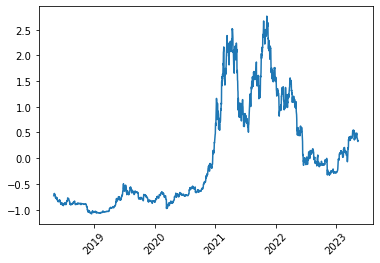

<Figure size 864x288 with 0 Axes>

In [75]:
# z-score closing price
plt.plot(data["Z_Close"])
plt.xticks(rotation=45)
plt.figure(figsize = (12,4))
plt.show()

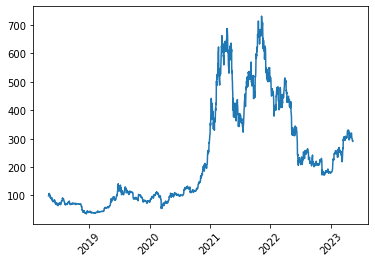

<Figure size 864x288 with 0 Axes>

In [76]:
# Normalized Closing Price
plt.plot(data["Close_norm"])
plt.xticks(rotation=45)
plt.figure(figsize = (12,4))
plt.show()

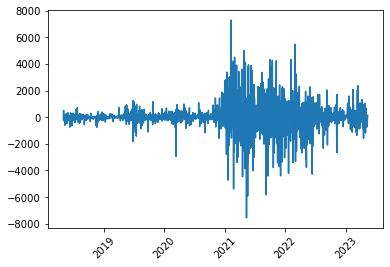

<Figure size 864x288 with 0 Axes>

In [77]:
# 1st Ordered Differenced Closing Price
plt.plot(data["Close_diff"])
plt.xticks(rotation=45)
plt.figure(figsize = (12,4))
plt.show()

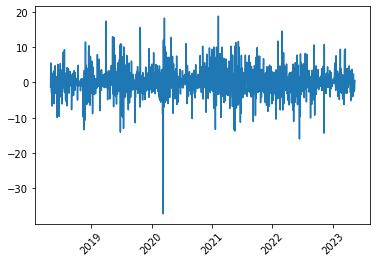

<Figure size 864x288 with 0 Axes>

In [78]:
# Percent Change in Cosing Prices
plt.plot(data["Close_pct"])
plt.xticks(rotation=45)
plt.figure(figsize = (12,4))
plt.show()

### 5. Testing the Stationarity using Augmented Dicky Fuller Test:

The Augmented Dicky Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are no. of unit root tests and ADF is one of the most widely used

1. Null Hypothesis (H0): Null hypothesis of the test is that the time series can be represented by a unit root that is not stationary.

2. Alternative Hypothesis (H1): Alternative Hypothesis of the test is that the time series is stationary.

Interpretation of p value

1. p value > 0.05 : Accepts the Null Hypothesis (H0), the data has a unit root and is non-stationary.

2. p value < = 0.05 : Rejects the Null Hypothesis (H0), the data is stationary.

In [79]:
def test_stationarity(x):

    #Perform Dickey Fuller test        
    print('Results of Dickey-Fuller Test:')
    result = adfuller(x, autolag='AIC')
    df_result = pd.Series(result[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    print (df_result)

In [80]:
for i in data.columns:
    print(i)
    test_stationarity(data[i])
    print("\n")

Close
Results of Dickey-Fuller Test:
Test Statistic                   -1.460430
p-value                           0.552987
Number of Lags Used              24.000000
Number of Observations Used    1815.000000
dtype: float64


Close_pct
Results of Dickey-Fuller Test:
Test Statistic                  -29.698503
p-value                           0.000000
Number of Lags Used               1.000000
Number of Observations Used    1838.000000
dtype: float64


Close_norm
Results of Dickey-Fuller Test:
Test Statistic                   -1.460430
p-value                           0.552987
Number of Lags Used              24.000000
Number of Observations Used    1815.000000
dtype: float64


Z_Close
Results of Dickey-Fuller Test:
Test Statistic                   -1.460430
p-value                           0.552987
Number of Lags Used              24.000000
Number of Observations Used    1815.000000
dtype: float64


Close_diff
Results of Dickey-Fuller Test:
Test Statistic                -8.450532e+00

Since the Close_diff series is the series of our major interest  and the 1st order differencing of the series has made the series stationary, we go ahead with plot ACF and PACF for the same.

### 6. Plotting the ACF and PACF plot for the data

### ACF 

The degree of resemblance between a certain time series and a lagged version of itself over subsequent time intervals is represented mathematically as autocorrelation (ACF). Autocorrelation is similar to the correlation between two different time series in theory, but it uses the same time series twice: once in its original form and again with one or more time periods added.

### PACF
A partial autocorrelation (PACF), on the other hand, is a description of the relationship between an observation in a time series and data from earlier time steps that do not take into account the correlations between the intervening observations. The correlation between observations at successive time steps is a linear function of the indirect correlations. These indirect connections are eliminated using the partial autocorrelation function.

ACF helps us identify the order for MA model whereas PACF helps us identify the order for AR model

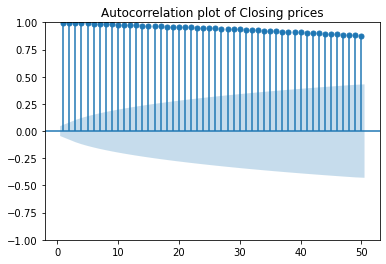

In [82]:
# ACF of the Closing Prices
sgt.plot_acf(data.Close, lags = 50, zero = False) #default lags=25
plt.title("Autocorrelation plot of Closing prices")
plt.show()

The above ACF plot shows high correlation because each time stamp has some information about the initial time stamp. Hence the lags show a slow decaying behavior. This is because the series has not been differenced for stationarity.

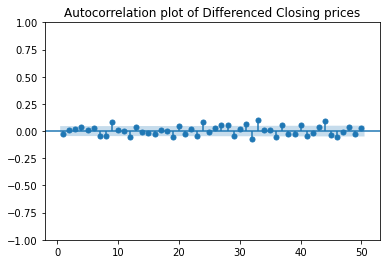

In [28]:
# ACF of Differenced Closing Prices
sgt.plot_acf(data.Close.diff().dropna(), lags = 50, zero = False)
plt.title("Autocorrelation plot of Differenced Closing prices")
plt.show()

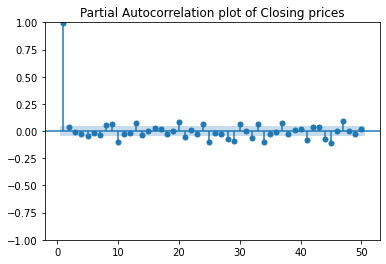

In [83]:
# PACF plot of Closing Prices
sgt.plot_pacf(data.Close, lags = 50, zero = False)
plt.title("Partial Autocorrelation plot of Closing prices")
plt.show()

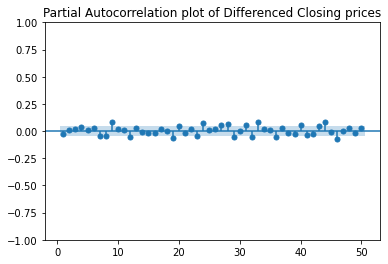

In [84]:
# PACF plot of Differenced Closing Prices

sgt.plot_pacf(data.Close_diff, lags = 50, zero = False)
plt.title("Partial Autocorrelation plot of Differenced Closing prices")
plt.show()

From the above graph, we can see that we have significant information until the 8th and 9th lag values.

### 8. Split the data

We now **Split** the data into Train and Test, keeping 20% of the observations in the test set. Considering the series **Close_diff** which containing the values for first order differencing

In [87]:
training_size = int(len(data)*0.80) 

train = data['Close_diff'].iloc[:training_size]
test = data['Close_diff'].iloc[training_size:]

print(data.shape)
print(train.shape) 
print(test.shape)

(1840, 5)
(1472,)
(368,)


### 9. Model Building

#### ARIMA

ARIMA is a combination of Autoregression (AR), Integrated (I) and Moving average (MA).

It is used for non-stationary data series.

Autoregression (AR): refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.

Integrated (I): represents the differencing of raw observations to allow for the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values). Order of Integration is the number of times differencing is required to make the series stationary.

Moving average (MA): incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

#### Steps to model AR, MA, ARMA:

Step 1: Analyze the time series plot to visualize stationarity, trend, Seasonality etc.

Step 2: Undertake testing of unit root test through DF, ADF, PP, KPSS etc. (Test for stationarity)

Step 3: Analyze both at ACF & PACF for the data both at level and 1st the data difference

Step 4: Decide order of AR and MA and finalize the possible of ARMA (p, q) models.

Step 5: Estimate the models



#### 9.1 Auto Regressive model

Auto regressive model is a time series forecasting model where current values are dependent on past values.

Since the PACF plot showed significance at 8th and 9th lag values, we will look at AR model of order 8 and 9

In [32]:
ar8 = ARIMA(train, order = (8,1,0)) # Since 1st order differencing was performed
result_ar8 = ar8.fit()
print(result_ar8.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1472
Model:                 ARIMA(8, 1, 0)   Log Likelihood              -12404.389
Date:                Tue, 08 Aug 2023   AIC                          24826.777
Time:                        19:21:02   BIC                          24874.420
Sample:                    05-01-2018   HQIC                         24844.543
                         - 05-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9257      0.017    -56.071      0.000      -0.958      -0.893
ar.L2         -0.8149      0.023    -35.558      0.000      -0.860      -0.770
ar.L3         -0.6916      0.026    -26.955      0.0

In [33]:
ar9 = ARIMA(train, order = (9,1,0))
result_ar9 = ar9.fit()
print(result_ar9.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1472
Model:                 ARIMA(9, 1, 0)   Log Likelihood              -12393.996
Date:                Tue, 08 Aug 2023   AIC                          24807.991
Time:                        19:21:02   BIC                          24860.928
Sample:                    05-01-2018   HQIC                         24827.732
                         - 05-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9480      0.017    -56.971      0.000      -0.981      -0.915
ar.L2         -0.8446      0.024    -35.913      0.000      -0.891      -0.799
ar.L3         -0.7274      0.026    -27.455      0.0

#### AIC Values of the model

In [34]:
print("AIC of AR(8) = ", result_ar8.aic)
print("AIC of AR(9) = ", result_ar9.aic)

AIC of AR(8) =  24826.77716128291
AIC of AR(9) =  24807.99140680203


AR(9) model is much significant here due to lower AIC value.

#### 9.2 Moving Average Model

In moving average model the series is dependent on past error terms.

Since the ACF plot showed significance at 8th and 9th lag values, we will look at MA model of order 8 and 9.

In [35]:
ma8 = ARIMA(train, order = (0,0,8))
result_ma8 = ma8.fit()
print(result_ma8.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1472
Model:                 ARIMA(0, 0, 8)   Log Likelihood              -12348.973
Date:                Tue, 08 Aug 2023   AIC                          24717.947
Time:                        19:21:03   BIC                          24770.891
Sample:                    05-01-2018   HQIC                         24737.689
                         - 05-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3803     28.722      0.466      0.641     -42.913      69.674
ma.L1         -0.0286      0.018     -1.552      0.121      -0.065       0.008
ma.L2          0.0157      0.017      0.924      0.3

In [36]:
ma9 = ARIMA(train, order = (0,0,9))
result_ma9 = ma9.fit()
print(result_ma9.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1472
Model:                 ARIMA(0, 0, 9)   Log Likelihood              -12342.940
Date:                Tue, 08 Aug 2023   AIC                          24707.881
Time:                        19:21:03   BIC                          24766.119
Sample:                    05-01-2018   HQIC                         24729.597
                         - 05-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3803     31.647      0.423      0.672     -48.646      75.407
ma.L1         -0.0375      0.018     -2.069      0.039      -0.073      -0.002
ma.L2          0.0142      0.017      0.831      0.4

In [37]:
print("AIC of MA(9) = ", result_ma8.aic)
print("AIC of MA(10) = ", result_ma9.aic)

AIC of MA(9) =  24717.946908457412
AIC of MA(10) =  24707.880762012792


AR(10) model is much significant here due to lower AIC value.

#### 9.3  Auto Regressive Integrated Moving Average Model

It is a combination of both AR and MA models. It makes the time series stationary by itself through the process of differencing. Therefore differencing need not be done explicitly for ARIMA model.

We now build ARIMA model of the order ARIMA(9,1, 10)

In [38]:
ar9_ma10 = ARIMA(train, order = (9,1,10))
result_ar9_ma10 = ar9_ma10.fit()
print(result_ar9_ma10.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1472
Model:                ARIMA(9, 1, 10)   Log Likelihood              -12321.204
Date:                Tue, 08 Aug 2023   AIC                          24682.408
Time:                        19:21:12   BIC                          24788.282
Sample:                    05-01-2018   HQIC                         24721.888
                         - 05-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.5211      0.300     -8.405      0.000      -3.109      -1.933
ar.L2         -4.1638      0.568     -7.327      0.000      -5.278      -3.050
ar.L3         -5.8686      0.910     -6.446      0.0

#### 9.3(a) - Split the data
Next, we will fit the ARIMA model on the training data and make predictions on the testing data.

In [39]:
training_size = int(len(data)*0.90) 

train_arima = data['Close'].iloc[:training_size]
test_arima = data['Close'].iloc[training_size:]

print(data.shape)
print(train_arima.shape) 
print(test_arima.shape)

(1840, 6)
(1656,)
(184,)


In [40]:
history = [x for x in train_arima]
predictions = []
for t in range(len(test_arima)):
  model = ARIMA(history, order=(9,0,10))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test_arima[t]
  history.append(obs)
  print('predicted=%f,expected=%f' %(yhat, obs))
    
  

predicted=16872.775208,expected=16799.185547
predicted=16862.183256,expected=16353.365234
predicted=16489.932621,expected=16618.199219
predicted=16622.173138,expected=16884.613281
predicted=17124.714423,expected=16669.439453
predicted=16529.659501,expected=16687.517578
predicted=16472.949407,expected=16697.777344
predicted=16802.527090,expected=16711.546875
predicted=16902.595102,expected=16291.832031
predicted=16395.655919,expected=15787.284180
predicted=15542.588506,expected=16189.769531
predicted=16364.044759,expected=16610.707031
predicted=16638.803340,expected=16604.464844
predicted=16543.946998,expected=16521.841797
predicted=16523.317856,expected=16464.281250
predicted=16628.823656,expected=16444.626953
predicted=16553.151173,expected=16217.322266
predicted=16085.860767,expected=16444.982422
predicted=16448.159196,expected=17168.566406
predicted=17154.524379,expected=16967.132812
predicted=17072.140216,expected=17088.660156
predicted=16990.722780,expected=16908.236328
predicted=

### 10. Evaluate the Performance of the model

 We will use the root mean squared error (RMSE) to evaluate the performance of our model.

In [90]:
ms_error = mean_squared_error(test_arima,predictions)
root_ms_error = math.sqrt(ms_error)
print('Root Mean Squared Error (RMSE): %.3f' % root_ms_error)

Root Mean Squared Error (RMSE): 584.328


**Inference:** We have used Root Mean Square Error(RMSE) as the error metric. RMSE signifies the average distance between predicted points on the test set and the actual (true) labels. In other words, it shows the extent of our error. The less this number, the better. We can see, that our model’s RMSE is not very big (consider that the price in our data set is in thousands of USD, and we are mistaken only by tens of USD).

### 11. Result Visualization

Finally, we will plot the predicted values against the actual values to visualize the accuracy of our model.

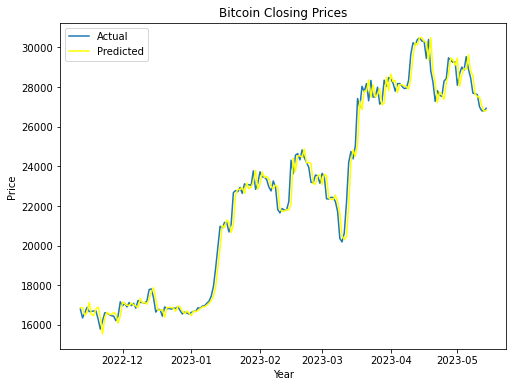

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(test_arima.index, test_arima, label='Actual')
plt.plot(test_arima.index, predictions, color='yellow', label='Predicted')
plt.title('Bitcoin Closing Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

**Inference:** The predicted and actual closing price are quite close to each other, the model is also capable of capturing the fluctuations in the values accurately.

### 11.1 Visualization of Estimated Residual plots

The deviations between actual values and predictions are called residuals. The plot for residuals is for AR,MA models is as follows:

In [49]:
data["resid_AR8"]= result_ar8.resid
data["resid_AR9"]= result_ar9.resid

data["resid_ma8"]= result_ma8.resid
data["resid_ma9"]= result_ma9.resid

Text(0.5, 1.0, 'PDF of Residual for MA(9)')

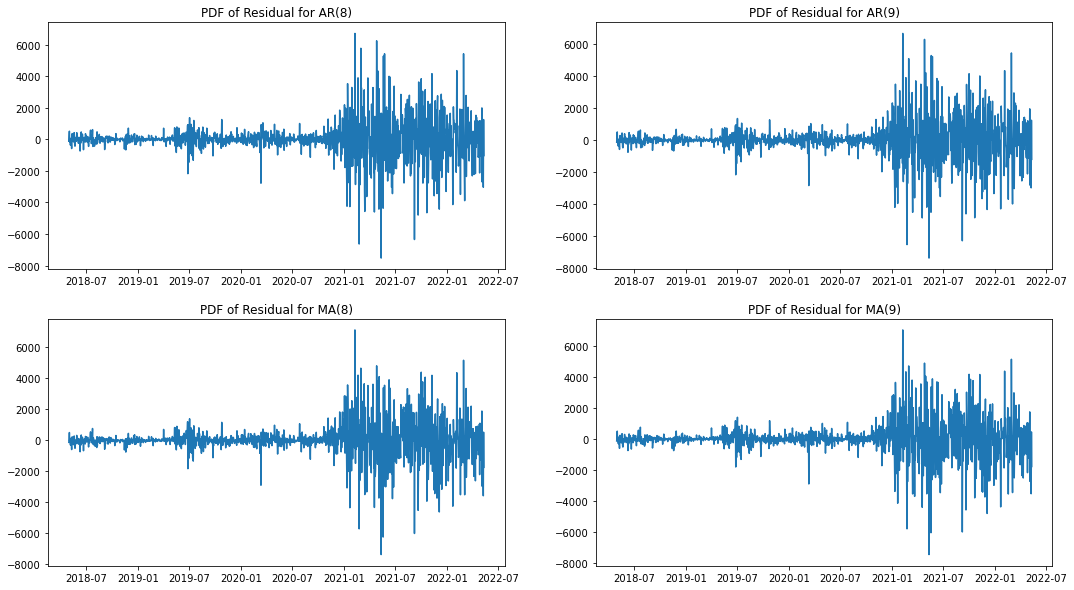

In [50]:
plt.figure(figsize = (18,10))
plt.subplot(2, 2, 1)
plt.plot(data["resid_AR8"])
plt.gca().set_title("PDF of Residual for AR(8)")

plt.subplot(2, 2, 2)
plt.plot(data["resid_AR9"])
plt.gca().set_title("PDF of Residual for AR(9)")

plt.subplot(2, 2, 3)
plt.plot(data["resid_ma8"])
plt.gca().set_title("PDF of Residual for MA(8)")

plt.subplot(2, 2, 4)
plt.plot(data["resid_ma9"])
plt.gca().set_title("PDF of Residual for MA(9)")